In [1]:
from source import *
import tensorflow as tf
from tensorflow.keras import layers

### Make an environment |'Pendulum-v1'|

State shape: (3,)
Action shape: (1,)


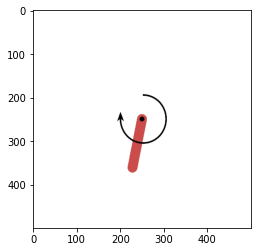

In [2]:
env_name = 'Pendulum-v1'

env = make_env(env_name)
env.reset()
plt.imshow(env.render("rgb_array"))
state_shape, action_shape = env.observation_space.shape, env.action_space.shape
print('State shape: {}'.format(state_shape))
print('Action shape: {}'.format(action_shape))
env.close()

### Build Policy Agent (Actor)

In [3]:
class MLPActor(tf.keras.Model):
    def __init__(self, state_dim, act_dim, act_limit):
        super().__init__()
        self.act_limit = act_limit
        self.fc1 = layers.Dense(256, activation="relu")
        self.fc2 = layers.Dense(256, activation="relu")
        self.actor = layers.Dense(act_dim)
    
    def call(self, s):
        x = self.fc1(s)
        x = self.fc2(x)
        x = self.actor(x)
        x = tf.keras.activations.tanh(x)  # to output in range(-1,1)
        x = self.act_limit * x
        return x

### Build Q-Network (Critic)

In [4]:
class MLPQFunction(tf.keras.Model):
    def __init__(self, state_dim, act_dim):
        super().__init__()
        self.fc1 = layers.Dense(256, activation="relu")
        self.fc2 = layers.Dense(256, activation="relu")
        self.Q = layers.Dense(1)
    
    def call(self, s, a):
        x = tf.concat([s,a], axis=-1)
        x = self.fc1(x)
        x = self.fc2(x)
        q = self.Q(x)
        return tf.squeeze(q, -1)

### Combine Actor and Critic models into a single model

In [5]:
class MLPActorCritic(tf.keras.Model):
    def __init__(self, observation_space, action_space):
        super().__init__()
        self.state_dim = observation_space.shape[0]
        self.act_dim = action_space.shape[0]
        self.act_limit = action_space.high[0]
        #build Q and policy functions
        self.q1 = MLPQFunction(self.state_dim, self.act_dim)
        self.q2 = MLPQFunction(self.state_dim, self.act_dim)
        self.policy = MLPActor(self.state_dim, self.act_dim, self.act_limit)
        
    def act(self, state):
        return self.policy(state).numpy()

    def get_action(self, s, noise_scale):
        a = self.act(s.reshape(1,-1).astype("float32")).reshape(-1)
        a += noise_scale * np.random.randn(self.act_dim)
        return np.clip(a, -self.act_limit, self.act_limit)

### Training Hyperparameters

In [6]:
steps_per_epoch = 4000
epochs = 5
replay_size = 1e6
batch_size = 64
update_every = 50
start_steps = 1e4

### Experience Buffer

In [7]:
replay_buffer = ReplayBuffer(replay_size)

### Make the environments

In [8]:
env = make_env(env_name)
test_env = make_env(env_name)

### Make an agent

In [9]:
agent = MLPActorCritic(env.observation_space, env.action_space)

2022-08-23 11:35:44.304040: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Train the agent

In [10]:
agent = td3(env, test_env, agent, steps_per_epoch=steps_per_epoch, epochs=epochs, replay_size=replay_size,
            batch_size=batch_size, update_every=update_every, start_steps=start_steps)

INFO:tensorflow:Assets written to: ram://d9c94fb6-758f-4899-9403-d57514e81af1/assets
INFO:tensorflow:Assets written to: ram://47316f23-4bd6-4442-b8d5-3063caf259c0/assets
INFO:tensorflow:Assets written to: ram://9f2b2541-bb6e-4b42-aa3a-d8b305cd9e68/assets
End of epoch: 1, Training Average Reward: -5011, Training Average Length: 1000
End of epoch: 1, Test Average Reward: -6004, Test Average Length: 1000
End of epoch: 2, Training Average Reward: -5978, Training Average Length: 1000
End of epoch: 2, Test Average Reward: -199, Test Average Length: 1000
End of epoch: 3, Training Average Reward: -2541, Training Average Length: 1000
End of epoch: 3, Test Average Reward: -109, Test Average Length: 1000
End of epoch: 4, Training Average Reward: -95, Training Average Length: 1000
End of epoch: 4, Test Average Reward: -64, Test Average Length: 1000
End of epoch: 5, Training Average Reward: -259, Training Average Length: 1000
End of epoch: 5, Test Average Reward: -140, Test Average Length: 1000


### Generate Animate of learned (trained) Policy Agent

In [11]:
# Animate learned policy
save_dir='./videos/td3/pendulum'
env = gym.make(env_name)
generate_animation(env, agent, save_dir=save_dir)
[filepath] = glob.glob(os.path.join(save_dir, '*.mp4'))
display_animation(filepath)

Reward: -118.61512428103882
